# Simulating HAT-P-1b observations with NIRISS/SOSS
--------------------------------------------------------------
**Author**: Néstor Espinoza (nespinoza@stsci.edu) | **Latest update**: August 22, 2020.

## Table of contents
1. [Introduction](#intro)
2. [Preparing planetary and stellar models](#preamble)
   1. [Obtaining a transit spectrum from ExoCTK](#tmodel)
   2. [Obtaining limb-darkening coefficients from ExoCTK](#lds)
3. [Simulating JWST observations of a transit of HAT-P-1b with NIRISS/SOSS](#simulation)
4. [Understanding the simulated data structure](#structure)

1.<font color='white'>-</font>Introduction <a class="anchor" id="intro"></a>
------------------

   Simulating JWST observations is an important part of the process of preparing ourselves for the type of precisions and challenges the observatory will be providing us with. This notebook is part of a series of notebooks that are being prepared by STScI in order to showcase how to simulate, process and analyze JWST observations for a wide range of science cases. Here, we touch on the transiting exoplanet observations science case and, in particular, on spectrophotometric observations of the *primary transit of an exoplanet*. During primary transit, the observed flux decrease due to the planet blocking light from the stellar host is proportional to $\delta = (R_p/R_*)^2$ --- a quantity known as the *transit depth*, where $R_p$ is the planetary radius and $R_*$ is the stellar radius. Interestingly, the transit depth is wavelength dependent; i.e., $\delta \equiv \delta (\lambda)$. This is because opacity sources on the planetary atmosphere absorb different amounts of light at different wavelengths and, therefore, the observed planetary radius $R_p$ --- and thus occulted area during transit, $\delta$ --- is wavelength-dependent (see, e.g., [Kreidberg 2018](https://ui.adsabs.harvard.edu/abs/2018haex.bookE.100K/abstract) for a review). This technique, referred to as *transmission spectroscopy* in what follows, aims at obtaining those transit depths as a function of wavelength in JWST observations through the study of ultra-precise transit lightcurves at different wavelengths. 
   
   In this notebook, we will simulate observations that aim to target a primary transit of HAT-P-1b in order to extract its *transmission spectrum*. This is a Guaranteed Time Observations (GTO) target of the [NIRISS Exploration of the Atmospheric diversity of Transiting exoplanets (NEAT) program](https://jwst-docs.stsci.edu/jwst-opportunities-and-policies/jwst-cycle-1-guaranteed-time-observations-call-for-proposals/jwst-gto-observation-specifications/jwst-gto-niriss-observations-table), which will be observed using the [NIRISS/SOSS](https://jwst-docs.stsci.edu/near-infrared-imager-and-slitless-spectrograph/niriss-observing-modes/niriss-single-object-slitless-spectroscopy) instrument onboard JWST. This target is also used as an [example science program used in the JWST documentation](https://jwst-docs.stsci.edu/near-infrared-imager-and-slitless-spectrograph/niriss-example-science-programs/niriss-soss-time-series-observations-of-hat-p-1). If you are not familiar with transiting exoplanet observations and/or with how JWST will observe planetary transits, we encourage you to read through that example science program in order to familiarize with the terminology.

   In essence, to perform NIRISS/SOSS simulations we need to simulate a time-series observation (TSO) [**exposure**, which is in turn composed of several integrations](https://jwst-docs.stsci.edu/understanding-exposure-times). To simulate a TSO exposure with this instrument, we will use the [Advanced Webb Exposure SIMulator for SOSS (`awesimsoss`)](https://github.com/spacetelescope/awesimsoss), which has built-in functions to simulate NIRISS/SOSS integrations incorporating exoplanetary transits. In what follows, **it will be assumed you have properly installed version 0.3.3 of `awesimsoss`**. In addition to this, you will need to have at hand a transmission spectrum (i.e., transit depths --- $(R_p/R_*)^2$ --- as a function of wavelength) model over the NIRISS/SOSS wavelength range ($0.6\mu$m - $3\mu$m) of your favorite exoplanet. [In the next section](#preamble) we introduce how to acquire those using publicly available tools from the [Exoplanet Characterization ToolKit (ExoCTK)](http://exoctk.stsci.edu/). If you already have that piece of data at hand, feel free to skip to the "[Simulating JWST observations of a transit of HAT-P-1b with NIRISS/SOSS](#simulations)" section.
   
Before we begin, we import all the needed libraries to this repository:

In [1]:
# Import numpy and matplotlib:
import numpy as np
import matplotlib.pyplot as plt
import os

# Import astropy units and utils to download files:
import astropy.units as q
from astropy.utils.data import download_file

# Import awesimsoss (the NIRISS/SOSS simulator), and batman, the transit lightcurve generator:
from awesimsoss import ModelTSO
import batman

Now, let's get to work!

2.<font color='white'>-</font>Preparing the planetary model for the simulations <a class="anchor" id="preamble"></a>
--------------------------------------------------------------------

To obtain a model transit spectrum for HAT-P-1b, we will use the [Generic Grid](https://exoctk.stsci.edu/generic) offered by the ExoCTK web service. Here we will input the properties of the planet and the star reported in [exo.MAST](https://exo.mast.stsci.edu/exomast_planet.html?planet=hatp1b), namely, an equilibrium temperature of $T_{eq} = 1323$ K, a planetary gravity of $7.47$ m/s$^2$, and a planetary and stellar radii of $R_p = 1.32R_J$ and $R_* = 1.17R_\odot$, respectively, where $R_J$ is Jupiter's and $R_\odot$ the Sun's radii. As for the planetary atmosphere parameters, we decide to use a model with rainout condensation because recent transmission spectroscopy studies in the optical region (see, e.g., [Todorov et al., 2019, A&A, 631, A169 and references therein](https://ui.adsabs.harvard.edu/abs/2019A%26A...631A.169T/abstract)) have shown no obvious prescence of TiO/VO in the atmosphere, which suggest it could have condensed and rained out from the terminator region. Given no strong constraints have been placed on the metallicity and C/O ratio of the atmosphere to date, we decide to use a solar metallicity and C/O ratio. Finally, we set the wavelength-dependent opacity to follow Rayleigh scattering in the tool, and assume a factor of 0.2 for the clouds, which is aconsistent with the results of Todorov et al. (2019) and previous studies on this planet (which do not clearly lean thowards cloudy or clear models).

Using these parameters, the online ExoCTK tool is able to find the closest transit spectrum to those parameters, which is one which has a slightly larger planetary gravity ($10$ instead of $7.47$ m/s$^2$). This produces a small offset on the transit depth with respect to the one observed in previous studies (e.g., Todorov et al. 2019), and thus we apply a small constant correction on the retrieved model in order to match that previous data. The corresponding (corrected) transit spectrum has been uploaded to a dedicated folder for this notebook; we retrieve it and plot it as follows:

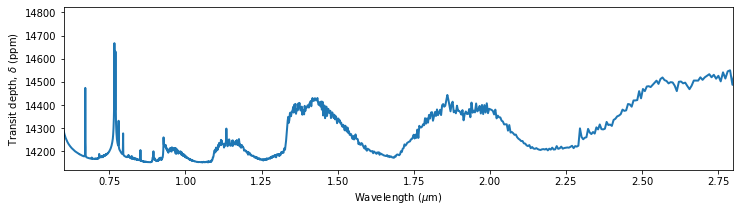

In [2]:
# Retrive transmission spectrum model:
file_path = download_file('https://data.science.stsci.edu/redirect/'+\
                          'JWST/jwst-data_analysis_tools/soss-transit-spectroscopy/data/hp1_tspec.dat')

wavelength, transit_depth = np.loadtxt(file_path,unpack=True)
plt.figure(figsize=(12,3))
plt.plot(wavelength, transit_depth*1e6,linewidth=2)
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Transit depth, $\delta$ (ppm)')
plt.xlim(0.6,2.8)
plt.show()

The most distinctive features in the NIRISS/SOSS wavelength range in the transit spectrum are (1) the large potassium feature at around $0.75\ \mu$m, along with (2) the large water features at around $1.5$, $2.0$ and $2.5\ \mu$m. Those are the features we will be targetting to observe with the simulations.

3.<font color='white'>-</font>Simulating JWST observations of a transit of HAT-P-1b with NIRISS/SOSS<a class="anchor" id="simulations"></a>
---------------------------------------------------------------------------------------

Equipped with the transit spectrum we want to inject in the simulations, we are now ready to use `awesimsoss` to simulate integrations of HAT-P-1b. Before generating them, we set the parameters of both the star and the planet (obtained from [exo.MAST](https://exo.mast.stsci.edu/exomast_planet.html?planet=hatp1b)), which will be ingested into the `awesimsoss` library to generate our simulated frames:

In [3]:
# First, define effective temperature, log(g), [Fe/H] and 
# 2MASS J-magnitude of the host star (the latter obtained from Simbad):
teff, logg, feh, jmag = 5980., 4.36, 0.13, 9.156

# Now define orbital properties of HAT-P-1b, the exoplanet. First, orbital period and time-of-transit center:
P, mid_transit_time = 4.4652998, 2459775.8911356
# Scaled semi-major axis and planet radius (in units of stellar radius), inclination, eccentricity and 
# argument of periastron passage:
a, rp, inc, ecc, omega = 10.22, 0.116, 85.79, 0., 253.1

Finally, we also set the properties of the NIRISS/SOSS exposure, namely, the duration of the entire exposure, the number integrations  and the number of groups, along with the time at which we wish the observations to start. All the numbers but the latter were already calculated in the [example science program of HAT-P-1 in the JWST documentation](https://jwst-docs.stsci.edu/near-infrared-imager-and-slitless-spectrograph/niriss-example-science-programs/niriss-soss-time-series-observations-of-hat-p-1/step-by-step-etc-guide-for-niriss-soss-time-series-observations-of-hat-p-1) (1,198 integrations, 3 groups per integration), and thus we fix those values to the numbers in that article here. As for when to start the observations, we pick a random observable JWST event: the transit ocurring at 09:23:14, July 15, 2022 (`2459775.8911356` in JD, i.e., epoch 820 from our transit ephemerides above). Because we want to start 3.534 hours (i.e., about 3 hours and 32 minutes) before this mid-transit time (to account for possible detector settling and to have enough baseline to correct possible systematics), we set the start time to `05:51:14` UT of the same day:

In [4]:
nintegrations, ngroups, start_time = 1198, 3, '2022-07-15T05:51:14'

We are now ready to use `awesimsoss`. We first create a `ModelTSO` object, which will initialize the properties of the simulated frame by assuming an input stellar spectrum using an ATLAS9 or PHOENIX model atmosphere as close as possible to our input stellar properties. By default, `awesimsoss` generates simulations using SUBSTRIP256, which contains both the optical and infrared orders of NIRISS/SOSS. We choose to model our star using an ATLAS9 model. On top of that, we define the currently allowed number of resets for NIRISS/SOSS observations (`nresets = 1`), and define the name of the target which will simply add the correct RA and DEC to the headers:

In [5]:
tsoframes = ModelTSO(ngrps=ngroups, nints=nintegrations, nresets = 1, teff = teff, logg = logg, 
                     feh = feh, jmag = jmag, stellar_model = 'ATLAS', obs_date = start_time, target = 'HAT-P-1', 
                     run = False)

Coordinates 344.4451845833333 38.67509861111111 for 'HAT-P-1' found in Simbad!


This `ModelTSO` object has a lot of information stored in it. One important piece is the time of each of the frames, which is stored in this case under `tsoframes.time`. To understand them, let's explore the first four times:

In [6]:
print('First three:',tsoframes.time[0],tsoframes.time[1],tsoframes.time[2])
print('Next one after thoese:',tsoframes.time[3])

First three: 2022-07-15T05:51:19.491 2022-07-15T05:51:24.982 2022-07-15T05:51:30.473
Next one after thoese: 2022-07-15T05:51:41.455


Note how the first frame time is not the `start_time`, but one frame time after that. That is because above we initiated the `ModelTSO` object with `nresets=1`, which means the first frame-time goes into a reset (so no data is stored). Then, after 3 frame times, the next frame-time that is stored is `2022-07-15T05:51:41.455`. Note that's two frame-times after the previous one --- again, the reason is that there is one extra frame-time due to the reset following the first three groups per integration.

Now, let's create the transit model that we will be injecting to the data. For this, we create a supersampled lightcurve of HAT-P-1 in order to account for the finite integration time of each of the frames:

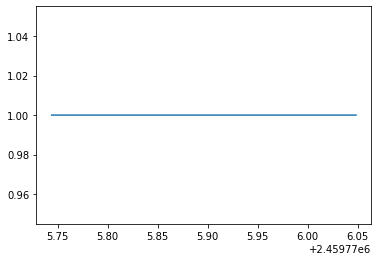

In [7]:
params = batman.TransitParams()
params.t0 = mid_transit_time - 1. # time of inferior conjunction; flat lightcurve on purpose!
params.per = P # orbital period (days)
params.a = a # semi-major axis (in units of stellar radii)
params.rp = rp # radius ratio for Jupiter orbiting the Sun
params.inc = inc # orbital inclination (in degrees)
params.ecc = ecc # eccentricity
params.w = omega # longitude of periastron (in degrees) p
params.limb_dark = 'quadratic' # limb darkening profile to use
params.u = [0.1,0.1] # limb darkening coefficients; just initializations for now
supersample_factor = 10

tmodel = batman.TransitModel(params, tsoframes.time.jd, 
                             supersample_factor = supersample_factor, exp_time = tsoframes.frame_time*(1./(3600.*24.)))

# Stellar parameters --- will be useful to generate limb-darkening coefficients internally in 
# awesimsoss:
tmodel.teff = teff
tmodel.logg = logg
tmodel.feh = feh
# Define ATLAS9 as the model grid:
tsoframes.model_grid = 'ATLAS9'
plt.plot(tsoframes.time.jd, tmodel.light_curve(params))

In [8]:
print(tsoframes.time.jd)

[2459775.74397559 2459775.74403914 2459775.7441027  ... 2459776.04826851
 2459776.04833206 2459776.04839561]


Given we will be using those times in the next notebooks to analyze the data, we save those into a numpy array:

In [9]:
np.save('times.npy',tsoframes.time.jd)

Finally, we now simulate the data. This will take a while:

In [10]:
# Define transit spectrum in a awesimsoss-friendly format:
transit_spectrum = [wavelength*q.um, transit_depth]

# Run if not ran already. Save to file:
outfile = 'data_uncal.fits'
if not os.path.exists(outfile):
    tsoframes.simulate(planet=transit_spectrum, tmodel=tmodel, 
                       params = params, supersample_factor = supersample_factor)
    tsoframes.export(outfile)

Could not determine exoctk version
Bandpass trimmed to 0.54982 um - 2.799 um
100 bins of 22 pixels each.
330 models loaded from /Users/nespinoza/exoctk_data/modelgrid/ATLAS9/
Loading flux into table...
Interpolating grid point [5980.0/4.36/0.13]...
Run time in seconds:  1.8384580612182617
Bandpass trimmed to 0.54982 um - 2.799 um
100 bins of 22 pixels each.
330 models loaded from /Users/nespinoza/exoctk_data/modelgrid/ATLAS9/
Loading flux into table...
Interpolating grid point [5980.0/4.36/0.13]...
Run time in seconds:  2.3617899417877197
Constructing frames for chunk 1/75...
Chunk 1/75 finished: 50.886 s
Constructing frames for chunk 2/75...
Chunk 2/75 finished: 91.052 s
Constructing frames for chunk 3/75...
Chunk 3/75 finished: 58.655 s
Constructing frames for chunk 4/75...
Chunk 4/75 finished: 60.036 s
Constructing frames for chunk 5/75...
Chunk 5/75 finished: 70.37 s
Constructing frames for chunk 6/75...
Chunk 6/75 finished: 104.19 s
Constructing frames for chunk 7/75...
Chunk 7/75

4.<font color='white'>-</font>Understanding the simulated data structure<a class="anchor" id="structure"></a>
---------------------------------------------------------------------------------------

Before moving forward to the next notebook, in which we'll reduce the data using the JWST pipeline, let's briefly explore the simulated and saved frames in order to understand the structure of the data. First, let's load the fits file to explore the data and headers:

In [11]:
from astropy.io import fits
hdul = fits.open(outfile)
# Print headers:
print(hdul[0].header.keys)
# Print data shape:
data = hdul[1].data
print('\nData shape :',data.shape)

<bound method Header.keys of SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
DATE    = '2020-08-21T19:57:37.818' / UTC date file created                     
FILENAME= 'data_uncal.fits'    / Name of the file                               
DATAMODL= 'RampModel'          / Type of data model                             
TELESCOP= 'JWST    '           / Telescope used to acquire the data             
                                                                                
        Observation identifiers                                                 
                                                                                
DATE-OBS= '2022-07-15'         / [yyyy-mm-dd] UTC date at start of exposure     

As can be seen from the above, the header of this uncalibrated file contains all the information about the exposure, from the start date of the exposure to the number of integrations, groups per integration, total duration of the exposure and instrument details (subarray, instrument, detector, etc.). As for the data shape, note this is an array of length $(N_{\textrm{integrations}},N_{\textrm{groups}},S,M)$, where $N_{\textrm{integrations}}$ is the number of integrations, $N_{\textrm{groups}}$ is the number of groups per integration, $S$ is the number of pixels in the subarray ("spatial") direction (256 in our case as we are using `SUBSTRIP256`) and $M$ is the number of pixles close to the "wavelength" direction (2048 in our case). At each of those coordinates, there will be a flux value in Digital Units (DUs).

Let's plot an image of the counts for the 5th integration on the 3rd group:

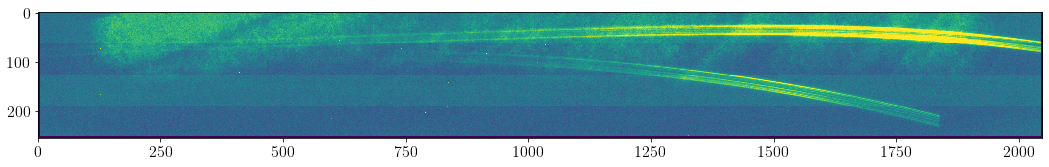

In [12]:
plt.figure(figsize=(18,18))
integration = data[5,2,:,:]
im = plt.imshow(integration)
im.set_clim(0,30000)

This frame shows the traces of the two orders --- the one on the top is the "order 1" trace, which covers from 1 to 3 microns, whereas the one in the bottom covers the optical range (from 0.6 to around 1 micron). Note the traces partially overlap in the leftside of the image --- a problem we will have to deal with in the future.

We now have our simulated data! Check the next notebooks to study how to calibrate and reduce this data.